In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Subtract, Dot
from tensorflow.keras.models import Model
from data_preparation import create_dataset, get_size
import math


## Loading Data
First, we need to load the data. Our X file contains word embedding of a query. all queries are resized to contain 21 phrases, and each phrase is represented by a 200 dim embedding. so our X's are `dataset_size * 21 * 200` vectors.

`Y` is indicating whether this vector was a `bad`, `neutral` or `good` query. So it is of size `3`

Download data files from [here](https://drive.google.com/drive/folders/18iHWo-gI4_IpNk7bkqvcbWGGDMQkLlVN?usp=sharing)

In [23]:

X = np.load('./dataset/train/x.npy', mmap_mode='r')
Y = np.load('./dataset/train/y.npy', mmap_mode='r')

# if set to True, labels will be in one-hot encodded format and output of neural network will be a 2 neuron dense layer with softmax activation to match it
ONE_HOT=False 
dataset = create_dataset((X,Y.argmax(axis=1)), [0,1,2], one_hot=ONE_HOT)
DATASET_SIZE = get_size(dataset)
# def convert(ds):
#     return {'input_1': ds[0], 'input_2': ds[1]}, ds[2]
# dataset = dataset.apply(convert)
# print_size(dataset)
print(dataset)
print(DATASET_SIZE)
# tfds.benchmark(dataset)

<ConcatenateDataset shapes: (((21, 200), (21, 200)), ()), types: ((tf.float64, tf.float64), tf.int32)>
70773


## Siamese Network
`Siamese Network` are usually used for one-shot classification, or comparing instances of data in computer vision. There are two sister network in them which works as a feature extraction phase. The network is fed two (or more) instances of data, let's say `x1` and `x2`. These two inputs go through the same network (on of the 'sisters') and the result of them are then subtracted (or any other function, like euclidean distance or whatever else) and the output of this subtraction layer is given to a dense network to decide whether they are of the same class. For example one of the main uses of siamese networks are in face recognition when you want to find similarity between your faces.
<img src="img/capture.png">
Here we first create our sister networks using Conv1D, then subtract the result of these two `feature extractors` and give the subtraction result to a dense layer to learn if they are similar or not.

In [18]:

def build_siamese_model(inputShape, output_shape = 64):
    regulizer =tf.keras.regularizers.l2( l=0.01)
    input = Input(shape=inputShape)
    text_layer = Conv1D(256, 5, activation='relu', kernel_regularizer=regulizer)(input)
    text_layer = MaxPooling1D(3)(text_layer)
    text_layer = Dropout(0.2)(text_layer)
    text_layer = Conv1D(256, 3, activation='relu',kernel_regularizer=regulizer)(text_layer)
    text_layer = MaxPooling1D(3)(text_layer)
    text_layer = Dropout(0.2)(text_layer)
    text_layer = GlobalMaxPooling1D()(text_layer)
    text_layer = Dense(256, activation='relu')(text_layer)
    output_layer = Dense(output_shape, activation='relu')(text_layer)
    model = Model(input, output_layer)
    model.summary()
    return model
input_shape = X.shape[1:]
txtA = Input(shape=input_shape, name='input_1')
txtB = Input(shape=input_shape, name='input_2')
featureExtractor  = build_siamese_model(input_shape)
featsA = featureExtractor(txtA)
featsB = featureExtractor(txtB)
distance = Subtract()([featsA, featsB])
# distance = Dot(axes=(1,1), normalize=True)([featsA, featsB])
distance = Dense(32, activation="relu")(distance)
if ONE_HOT:
    outputs = Dense(2, activation="softmax")(distance)
else:
    outputs = Dense(1, activation='sigmoid')(distance)
model = Model(name= 'model',inputs=(txtA, txtB), outputs=outputs)
model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 21, 200)]         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 17, 256)           256256    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 5, 256)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 3, 256)            196864    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1, 256)            0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 256)            0   

In [19]:
def fit_model(model, ds, val_split = 0.1,batch_size = 128, **kwargs):
  optimizers = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD"
  )
  model.compile(optimizer=optimizers,
              loss='binary_crossentropy',
              metrics=['acc'])
  ds = ds.shuffle(2048).repeat()
  val_size = round(val_split * DATASET_SIZE)
  train_size = round((1 - val_split) * DATASET_SIZE)
  val_ds = ds.take(val_size).batch(min(val_size, BATCH_SIZE))
  train_ds = ds.skip(val_size).batch(batch_size)
  train_steps = math.ceil(train_size // batch_size)
  val_step = max(val_size // batch_size, 1)
  return model.fit(train_ds, steps_per_epoch=train_steps ,validation_data=val_ds,validation_steps=val_step,**kwargs)


In [20]:
BATCH_SIZE = 64

history = fit_model(model, dataset, val_split=0.2, epochs=10, batch_size=BATCH_SIZE)

Epoch 1/10
884/884 [==============================] - 240s 209ms/step - loss: 4.5441 - acc: 0.7517 - val_loss: 4.8466 - val_acc: 0.3001
Epoch 2/10
884/884 [==============================] - 172s 194ms/step - loss: 3.3477 - acc: 0.7809 - val_loss: 2.9377 - val_acc: 0.7716
Epoch 3/10
884/884 [==============================] - 167s 189ms/step - loss: 2.3699 - acc: 0.8563 - val_loss: 2.7781 - val_acc: 0.7163
Epoch 4/10
884/884 [==============================] - 208s 235ms/step - loss: 1.7251 - acc: 0.8930 - val_loss: 1.7271 - val_acc: 0.7630
Epoch 5/10
884/884 [==============================] - 227s 257ms/step - loss: 1.3444 - acc: 0.8702 - val_loss: 1.7167 - val_acc: 0.7511
Epoch 6/10
884/884 [==============================] - 252s 285ms/step - loss: 0.9565 - acc: 0.9134 - val_loss: 2.7824 - val_acc: 0.6545
Epoch 7/10
884/884 [==============================] - 359s 407ms/step - loss: 0.8639 - acc: 0.8729 - val_loss: 1.0503 - val_acc: 0.7509
Epoch 8/10
884/884 [============================

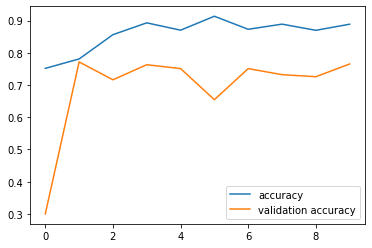

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['accuracy','validation accuracy'])

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sn
# from sklearn.metrics import ConfusionMatrixDisplay

# y_pred = model.predict(X_t)
# y_pred
# cm = confusion_matrix(Y_t.argmax(axis=1), y_pred.argmax(axis=1))

# display_labels = ['Bad', 'Neutral', 'Good']
# df_cm = pd.DataFrame(cm,index=display_labels, columns=display_labels)

# # plt.figure(figsize=(10,7))
# sn.set(font_scale=1.4) # for label size
# sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
# plt.figure(figsize = (15,12))

# # disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               # display_labels=display_labels)
# # disp = disp.plot(include_values=True,
#                 #  cmap='viridis', ax=None, xticks_rotation='horizontal')
# plt.show()
# # print('recall', tp / (tp + fn))
# # print('precision', tp / (tp + fp))
# # print('acc', tp + tn / (tp + tn + fp + fn))

In [22]:
model.save('models/siamese_nework')

C:\Users\Hamid\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: models/siamese_nework\assets
